In [5]:
import pandas as pd
import numpy as np

# Specify base name
feature_name = 'EOF_8tsuv'
model_name = 'example_model'

# Get from R and then transform to biological space
X_GDM_predictors = pd.read_csv(f"/cluster/home/haroldh/spGDMM/1_data/2_processed/prediction/{feature_name}_predictors.csv")

# Get posterior samples for beta coefficients from the trained model.
# These represent the estimated effects of predictors on dissimilarity.
# For each feature (mode or statistic) there will be df splines, adding in the intercept there will be dxdf + df beta coefficients.
# TODO Figure out how many psi coefficients and why
beta_posts = pd.read_csv(f"/cluster/home/haroldh/spGDMM/4_trained_models/{model_name}_{feature_name}_post_samples.csv")
beta_posts = beta_posts.drop(columns=['Unnamed: 0'])

In [6]:
# Define the log_beta_columns variable
log_beta_columns = [col for col in beta_posts.columns if 'log_beta' in col]

log_beta_indices = [beta_posts.columns.get_loc(col) for col in log_beta_columns]
start_idx, stop_idx = log_beta_indices[0], log_beta_indices[-1]

In [7]:
# Get df
df = 5

# TODO Research best methods for choosing the best beta coefficients
# Here we use the mean
X_GDM_weighted = X_GDM_predictors * beta_posts.mean(axis=0)[start_idx+df:stop_idx+1].values

# Step 2: Sum every df columns (df bases per feature)
n_grids, n_bases = X_GDM_weighted.shape
num_features = int(n_bases / df)

X_GDM_weighted_summed = np.reshape(X_GDM_weighted.values, (n_grids, num_features, df)).sum(axis=2)

In [8]:
# Sum of the first 5 rows of X_GDM_weighted
sum_first_5_rows = X_GDM_weighted.iloc[-1,:5].sum()
print("Sum of the first 5 rows of X_GDM_weighted:", sum_first_5_rows)

# First value of X_GDM_weighted_summed
first_value_summed = X_GDM_weighted_summed[-1, 0]
print("First value of X_GDM_weighted_summed:", first_value_summed)

assert sum_first_5_rows == first_value_summed

Sum of the first 5 rows of X_GDM_weighted: -32.761375399153046
First value of X_GDM_weighted_summed: -32.761375399153046


In [9]:
from sklearn.decomposition import PCA

X_GDM__weighted_summed_no_nan = X_GDM_weighted_summed[~np.isnan(X_GDM_weighted_summed).any(axis=1)]

# Perform PCA
pca = PCA()
X_GDM__weighted_summed_no_nan_pca = pca.fit_transform(X_GDM__weighted_summed_no_nan)

# Print the explained variance ratio of the top 3 components
print("Explained variance ratio of the top 3 components:", pca.explained_variance_ratio_[:3])
# Print the sum of the explained variance ratio of the top 3 components
print("Sum of the explained variance ratio of the top 3 components:", pca.explained_variance_ratio_[:3].sum())

Explained variance ratio of the top 3 components: [0.31469694 0.2065005  0.16253279]
Sum of the explained variance ratio of the top 3 components: 0.6837302300234622


In [108]:
X_GDM_weighted_summed.shape

(527250, 8)

In [3]:
import xarray as xr

eof_features = xr.open_dataarray(f'/cluster/home/haroldh/spGDMM/1_data/4_interim/{feature_name}_features.nc')
eof_features

<xarray.DataArray (mode: 8, yc: 555, xc: 950, time: 365)> Size: 12GB
[1539570000 values with dtype=float64]
Coordinates:
  * yc       (yc) float32 2kB 800.0 1.6e+03 2.4e+03 ... 4.432e+05 4.44e+05
  * xc       (xc) float32 4kB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
  * mode     (mode) int64 64B 1 2 3 4 5 6 7 8
  * time     (time) int64 3kB 0 1 2 3 4 5 6 7 ... 358 359 360 361 362 363 364
Attributes: (12/18)
    center:         True
    check_nans:     True
    compute:        True
    date:           2025-01-15 16:32:52
    feature_name:   feature
    model:          EOF analysis
    ...             ...
    use_coslat:     False
    version:        3.0.4
    60% threshold:  
    70% threshold:  
    80% threshold:  
    broken_stick:

In [11]:
import xarray as xr

eof_features = xr.open_dataarray(f'/cluster/home/haroldh/spGDMM/1_data/4_interim/{feature_name}_features.nc')

combined = eof_features.isel(mode=0,time=0).stack(grid=['yc', 'xc'])

# Extract the coordinate pairs for each stacked grid cell
coordinates = np.column_stack([combined['xc'].values, combined['yc'].values])

valid_coordinates = coordinates[~np.isnan(combined).values]

print(coordinates.shape)

# Check combined nans are same location as collapsed_X_GDM nans
# Check if the NaN indices in combined match those in collapsed_X_GDM
combined_nan_indices = np.isnan(combined.values)
collapsed_nan_indices = np.isnan(X_GDM_weighted_summed[:,0])

# Verify if the indices are the same
if np.array_equal(combined_nan_indices, collapsed_nan_indices):
    print("The NaN indices match between combined and X_GDM_weighted_summed.")
else:
    print("The NaN indices do not match between combined and X_GDM_weighted_summed.")
    # Find how many don't match
    mismatch_count = np.sum(combined_nan_indices != collapsed_nan_indices)
    print(f"Number of mismatched NaN indices: {mismatch_count}")

combined_no_nans = combined.dropna(dim='grid', how='any')
combined_no_nans

(527250, 2)
The NaN indices do not match between combined and X_GDM_weighted_summed.
Number of mismatched NaN indices: 102334


<xarray.DataArray (grid: 527250)> Size: 4MB
array([ 0.        ,  0.        ,  0.        , ..., -1.0180767 ,
       -1.01858632, -1.02114851])
Coordinates:
    mode     int64 8B 1
    time     int64 8B 0
  * grid     (grid) object 4MB MultiIndex
  * yc       (grid) float32 2MB 800.0 800.0 800.0 ... 4.44e+05 4.44e+05 4.44e+05
  * xc       (grid) float32 2MB 800.0 1.6e+03 2.4e+03 ... 7.592e+05 7.6e+05
Attributes: (12/18)
    center:         True
    check_nans:     True
    compute:        True
    date:           2025-01-15 16:32:52
    feature_name:   feature
    model:          EOF analysis
    ...             ...
    use_coslat:     False
    version:        3.0.4
    60% threshold:  
    70% threshold:  
    80% threshold:  
    broken_stick:

NameError: name 'valid_coordinates' is not defined

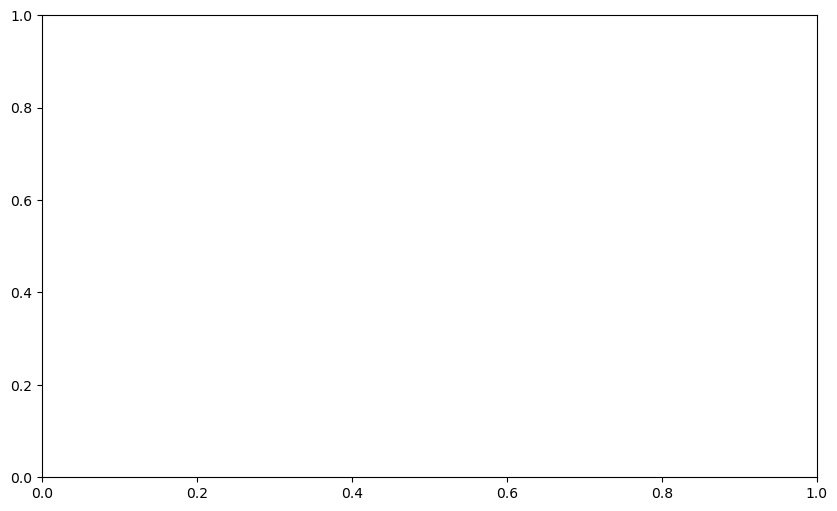

In [98]:
import matplotlib.pyplot as plt

# Now we have the co-ordinates for each PCA value, so let's plot
X_GDM__weighted_summed_no_nan_pca

# TODO APPROPRIATELY CHOOSE A STANDARDISATION METHOD
# E.g. Incoporate the explained variance somehow, 
# Standardize each column between 0 and 1 based on max value

# Normalize the PCA data to the range [0, 1] for RGB plotting
normalized_pca = (X_GDM__weighted_summed_no_nan_pca - X_GDM__weighted_summed_no_nan_pca.min(axis=0)) / (X_GDM__weighted_summed_no_nan_pca.max(axis=0) - X_GDM__weighted_summed_no_nan_pca.min(axis=0))

# Combine the three PCA components into an RGB image
rgb_image = normalized_pca[:, :3]

# Plot the combined RGB image
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(valid_coordinates[:, 0], valid_coordinates[:, 1], c=rgb_image, marker='o')
ax.set_title('PCA Components as RGB')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Plot each PCA component individually with red, green, and blue gradients
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, color in enumerate(['Reds', 'Greens', 'Blues']):
    ax = axes[i]
    # Use the corresponding color map for each PCA component
    sc = ax.scatter(valid_coordinates[:, 0], valid_coordinates[:, 1], c=normalized_pca[:, i], cmap=color, marker='o')
    ax.set_title(f'PCA Component {i+1} ({color})')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.colorbar(sc, ax=ax, label='Normalized Value')

plt.tight_layout()
plt.show()

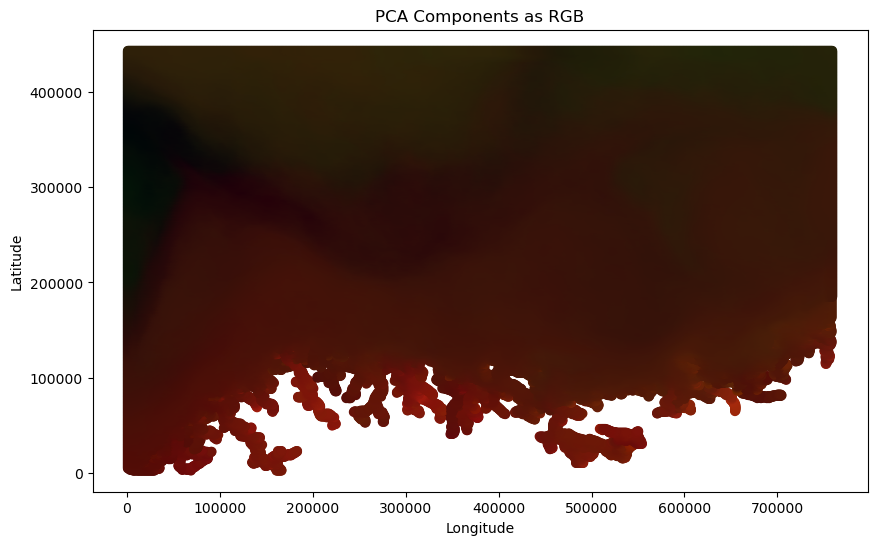

In [195]:
# Scale be explained variance ratio
# Explained variance ratio (assuming collapsed_X_GDM_pca is a PCA output)
explained_variance_ratio = pca.explained_variance_ratio_[:3]

# Scale normalized PCA components by explained variance
weighted_pca = normalized_pca[:, :3] * explained_variance_ratio

# Combine into RGB
rgb_image = weighted_pca

# Plot the combined RGB image
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(valid_coordinates[:, 0], valid_coordinates[:, 1], c=rgb_image, marker='o')
ax.set_title('PCA Components as RGB')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


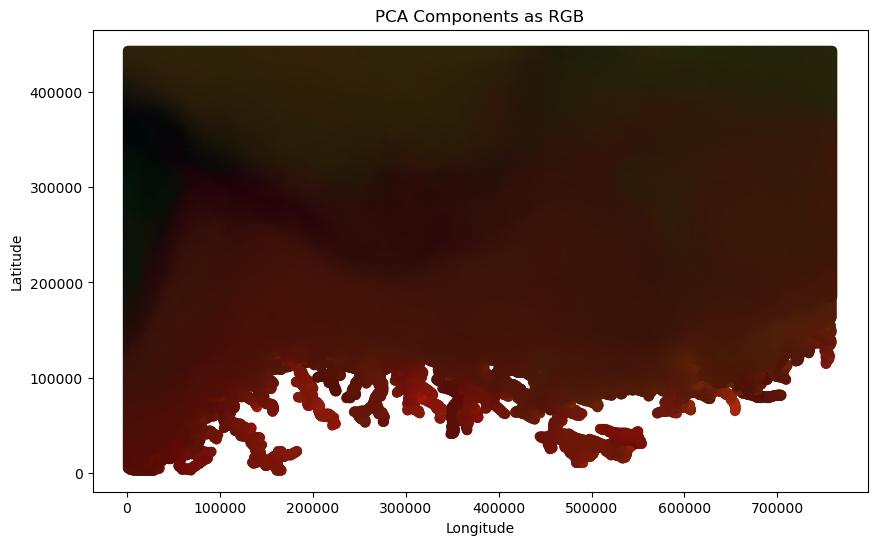

In [196]:
# Scale by total variance (sum of explained variance)
total_variance_ratio = explained_variance_ratio / explained_variance_ratio.sum()

# Weight each PCA component by total variance contribution
weighted_pca = normalized_pca[:, :3] * total_variance_ratio

# Combine into RGB
rgb_image = weighted_pca

# Plot the combined RGB image
fig, ax = plt.subplots(figsize=(10, 6))
sc = ax.scatter(valid_coordinates[:, 0], valid_coordinates[:, 1], c=rgb_image, marker='o')
ax.set_title('PCA Components as RGB')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()